In [1]:
import os
import re
import numpy as np
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

VERBOSE = 2
EPOCHS = 40
BATCH_SIZE = 16

DIM = 1024
IMAGE_SIZE = (1024,1024)
IMAGE_SHAPE = (1024,1024,3)

strategy = tf.distribute.get_strategy() 
REPLICAS = strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Using default strategy for CPU and single GPU")
print("REPLICAS:", REPLICAS)

Num GPUs Available:  0
Using default strategy for CPU and single GPU
REPLICAS: 1


In [2]:
print("Tensorflow version " + tf.__version__)
cwd = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

Tensorflow version 2.4.0


In [3]:
TRAINING_FILENAMES = tf.io.gfile.glob(cwd + "/data/train*.tfrec")[:10]
VALIDATION_FILENAMES = tf.io.gfile.glob(cwd + "/data/train*.tfrec")[10:16]
TEST_FILENAMES = tf.io.gfile.glob(cwd + "/data/test*.tfrec")

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALIDATION_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 10
Validation TFRecord Files: 5
Test TFRecord Files: 16


In [4]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [5]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    
    return example['image'], example['target']

In [6]:
def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

In [7]:
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.image.resize(img, [dim, dim]) 

    return img

In [8]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [9]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), num_parallel_calls=AUTOTUNE)      
    
    ds = ds.map(lambda img, imgname_or_label: (
        prepare_image(img, augment=augment, dim=dim), imgname_or_label), 
        num_parallel_calls=AUTOTUNE
    )
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [14]:
train_ds = get_dataset(TRAINING_FILENAMES, augment=False, shuffle=False, repeat=False, dim=DIM, batch_size = 6)

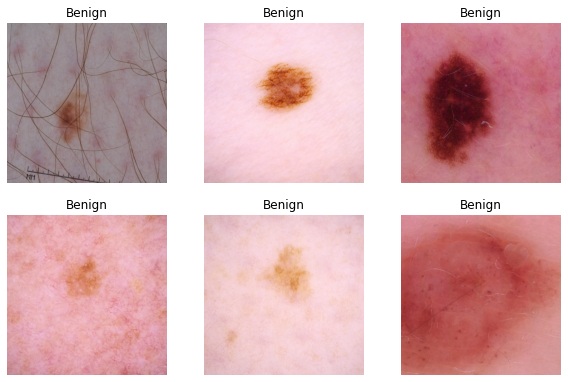

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): 
  for i in range(6):
    finding = "Benign" if labels[i].numpy() == 0 else "Malignant" 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(finding)
    plt.axis("off")

In [16]:
train_ds = get_dataset(TRAINING_FILENAMES, augment=True, shuffle=False, repeat=False, dim=DIM, batch_size = 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


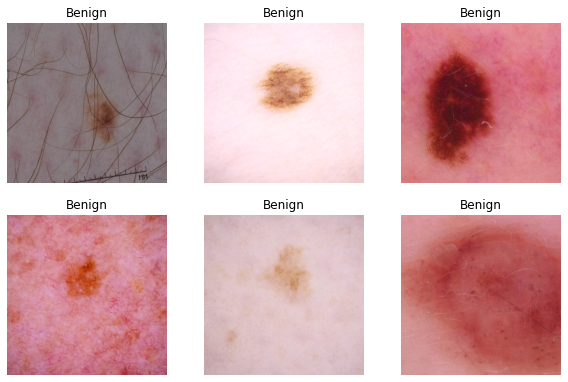

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): 
  for i in range(6):
    finding = "Benign" if labels[i].numpy() == 0 else "Malignant" 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(finding)
    plt.axis("off")

In [13]:
with tf.Graph().as_default():

    with strategy.scope():
        files_train = count_data_items(TRAINING_FILENAMES)
        steps_per_epoch=files_train/BATCH_SIZE//REPLICAS

        inp = tf.keras.layers.Input(shape=IMAGE_SHAPE)
        base = efn.EfficientNetB6(input_shape=IMAGE_SHAPE,weights='imagenet',include_top=False)

        x = base(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inp,outputs=x)
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 

        model.compile(optimizer=opt,loss=loss,metrics=['AUC'])

        model.summary()

        history = model.fit(
            train_ds, 
            epochs=EPOCHS, 
            callbacks = [get_lr_callback()], 
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            verbose=VERBOSE
        )


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
efficientnet-b6 (Functional) (None, 32, 32, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2305      
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________
